# Data mining New York Times articles
by Harshini Konduri, Pallavi Damle, Shantanu Saha, Harshvardhan Shukla, Koba Khitalishvili


## Introduction
In our project we explore Natural Language Processing by mining the New York Times articles. The basic idea was to see if it is possible to classify the articles by topic using the article abstracts. By classifying the articles we are able to obtain the most important words for each topic using the feature importances generated by the classifier. Potential use would be for marketing purposes to see what keywords are trending for a given topic. 

We are using open source tools like machine learning python library Scikit-learn and Beautiful soup for web scraping. We are proponents of reproducible research and you can find all our code at https://github.com/KobaKhit/Data-mining-using-NLP .

## Results
### Data preparation
Initially, we wrote a python script that scraped new york times articles for information like date published, author, and most importantly the body of text. However, some articles are private and cannot be scraped. Additionally, the webscraping was slow. As a result, we wrote a different script ,`nytsnippetgetter.py`, that sends direct http search request to the www.nytimes.com/ server and gets a `json` response instantly. Instead of the body of text we get a snippet which can be the first leading paragraph, a summary, or an abstract. We were able to obtain 36 thousand article abstracts and other information in less than 5 minutes. After preprocessing the raw text data and obtaining the TFxIDF statistics for each word across all articles we use the multinomial Naive Bayes model for classification. 

### Classification
You can see in appendix that our model has 100% accuracy on test data when classifying by article topic which basically means that the New York Times search engine is efficient. However, when classifying articles from different time periods by author the accuracy of the model is only 0.8. In every instance we provide the most important words by topic (author).

So far we found out that New York Times has a superb search engine and that authors from distinct time periods had different vocabularly which is sort of obvious. At this point we are continueing our reserch in several directions. 

We look at comparing word clouds at different time points and how vocabularly changed with time. We have access to articles dating as early as 1921. To do so we decided to use the Topic modelling by latent Dirichlet allocation. There is an implimentation of the algorithm for python called the `lda` package. However, scikit-learn has an implementation of the same algorithm as well ([sklearn.decomposition.LatentDirichletAllocation](http://scikit-learn.org/dev/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)). We were inspired by Blei's approach of topic modelling (2012).

We also want to test whether its possible  to classify articles obtained from different news sources using NY Times articles as training data. 


## Conclusion
Going forward we want to focus on data preprocessing. Namely, edit the corpus of the articles and remove redundant words like prepositions. In this way we will be able to capture most important words by topic. According to Blei, efficient topic modeling increases the relevance and flexibility of any text data search results. 

Additionaly, we would like to make use of other classifiers like RandomForest and Support vector machines and maybe an ensemble method.

## References 
  - Blei, David. Probabilistic Topic Models. *Communications of the ACM*. April 2012. vol. 55. no. 4
  
## Appendix

In [1]:
from nytsnippetgetter import get_data
import time, os.path, json, re

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

# start timer
start_time = time.time()

# get available number of pages for each topic. Each page is equivalent to 10 articles
topics=['economics','politics','espionage','global+warming', 'donald+trump','hillary+clinton', 
        'bernie+sanders', 'guns', 'cancer', 'sex']
ndocs = [500]
# topics=['economics','politics']
get_data(topics, BEGINDATE = 20131213, LIMITS=True) # articles written since 2013-December-13

Total number of articles available:  64699
Date range:  20160529 -> 20131213 

economics :  4759
politics :  19914
espionage :  1204
global+warming :  2113
donald+trump :  5668
hillary+clinton :  6226
bernie+sanders :  2894
guns :  3501
cancer :  7969
sex :  10451


In [2]:
if os.path.isfile("../scripts/2016-05-11-election-data.json"):
    # load saved data
    with open('../scripts/2016-05-11-election-data.json') as json_data:
        articles = json.load(json_data)["data"]
    print("Loaded " + str(len(articles)) + " articles.")
else:
    # download article data 
    # articles = get_data(TOPICS = topics, NPAGES = npages, BEGINDATE = 20131213)
    articles = get_data(topics, ndocs, BEGINDATE=20140101, FILENAME='example.json')
    # articles = get_data(TOPICS = topics, BEGINDATE = 20131213, NPAGES = [15,10])

Loaded 20961 articles.


In [3]:
# articles is a list of objects with each object being one document
articles[0]

{'abstract': 'Mr. Sanders is on a roll, and Mr. Trump is moving closer to his most likely uncontested nomination.',
 'author': 'ELIZABETH WILLIAMSON',
 'date_modified': '2016-05-11T03:30:28Z',
 'date_published': '2016-05-10T23:29:34Z',
 'keywords': [{'name': 'persons',
   'rank': '1',
   'value': 'Clinton, Hillary Rodham'},
  {'name': 'persons', 'rank': '2', 'value': 'Obama, Barack'},
  {'name': 'persons', 'rank': '3', 'value': 'Ryan, Paul D Jr'},
  {'name': 'persons', 'rank': '4', 'value': 'Sanders, Bernard'},
  {'name': 'persons', 'rank': '5', 'value': 'Trump, Donald J'},
  {'name': 'persons', 'rank': '6', 'value': 'Warren, Elizabeth'},
  {'name': 'glocations', 'rank': '1', 'value': 'Eugene (Ore)'},
  {'name': 'glocations', 'rank': '2', 'value': 'Indiana'},
  {'name': 'glocations', 'rank': '3', 'value': 'Kentucky'},
  {'name': 'glocations', 'rank': '4', 'value': 'Massachusetts'},
  {'name': 'glocations', 'rank': '5', 'value': 'Nebraska'},
  {'name': 'glocations', 'rank': '6', 'value'

In [4]:
# retain unique articles
unique_articles = []
data = [x['snippet'] for x in unique_articles]
for i in articles:
    if i['snippet'] not in data: 
        unique_articles.append(i)
        
# some articles are missing lead paragraph and abstract. just use snippets for now
data = [re.sub(r'(<.*>)','',x['snippet']) for x in unique_articles if x['user_topic'] in 
        ['donald+trump','hillary+clinton', 'bernie+sanders', 'ted+cruz']]
words = set([ y for x in unique_articles for y in x['snippet'].split(" ")])

# show html tags
[x for x in words if "<" in x][0:5]

['<strong>Clinton</strong>;',
 '<strong>Bernie</strong>',
 '<strong>Hillary</strong>.”',
 '<strong>Trump</strong>-voting',
 '<strong>Clinton</strong>']

In [5]:
# number of articles
print("N articles: ", len(data))
print("N unique articles: ", len(set(data)))
print("N unique words: ", len(set([ y for x in data for y in x.split(" ")])))

# words
[y for x in data for y in x.split(" ")][0:5]

N articles:  17327
N unique articles:  10224
N unique words:  28513


['in', 'West', 'Virginia’s', 'presidential', 'primary,']

In [6]:
# https://pypi.python.org/pypi/lda
# http://stackoverflow.com/questions/20984841/topic-distribution-how-do-we-see-which-document-belong-to-which-topic-after-doi
# stoplist = set('for a of the and to in'.split())
# data = [[word for word in document.lower().split() if word not in stoplist]
#          for document in documents]

# check if data has Nones
nonesidx = [data.index(x) for x in data if x == None and len(x) > 0]
if len(nonesidx) > 0:
    print("You have nones. Below are indices of articles.")
    print(nonesidx)
else:
    print("No Nones. Good to go.")
    
data[0:3]

No Nones. Good to go.


['in West Virginia’s presidential primary, and a vow to win the Democratic nomination, no matter how unlikely that seems.  notched two unopposed wins in West Virginia and Nebraska, moving closer to his',
 ' J. Trump’s campaign aides said that because of a technical glitch, a well-known white nationalist leader was included on a list of California delegates that they submitted to the secretary of state’s office. It was the',
 'Your daily look at late-breaking news, upcoming events and the stories that will be talked about Wednesday: 1.  TELLS AP HE WILL KEEP BANKING ON CHARISMA, RALLIES "My best investment is my rallies" to help amass more support,']

In [7]:
# article topics
label = [ x['user_topic'] for x in unique_articles if x['user_topic'] in 
        ['donald+trump','hillary+clinton', 'bernie+sanders', 'ted+cruz']]
label[-5:-1]

['ted+cruz', 'ted+cruz', 'ted+cruz', 'ted+cruz']

In [8]:
# http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Convert raw documents to a matrix of TF-IDF features.
vectorizer = TfidfVectorizer(stop_words = "english", ngram_range =(1,2)
                            #,max_features = 50000
                             )

# Encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder() 

vectors = vectorizer.fit_transform(data) 
target = le.fit_transform(label)

print(vectors.shape, target.shape,'\n')
print("Number of columns: ", vectors.shape[1], '\n')
print("(docid, wordid) TFIDF", '\n')
print(vectors[0,])

(17327, 112061) (17327,) 

Number of columns:  112061 

(docid, wordid) TFIDF 

  (0, 61287)	0.173648123916
  (0, 62559)	0.200628881672
  (0, 106171)	0.183033993878
  (0, 109995)	0.209048722457
  (0, 104206)	0.209048722457
  (0, 64471)	0.209048722457
  (0, 104162)	0.209048722457
  (0, 58144)	0.194654909564
  (0, 63925)	0.200628881672
  (0, 27638)	0.114703196937
  (0, 109671)	0.164608360007
  (0, 107145)	0.200628881672
  (0, 74216)	0.200628881672
  (0, 73535)	0.121734569659
  (0, 106172)	0.200628881672
  (0, 109299)	0.298055204419
  (0, 19355)	0.132971631856
  (0, 61281)	0.147904848646
  (0, 62545)	0.146326934232
  (0, 109941)	0.116550269978
  (0, 104205)	0.209048722457
  (0, 64467)	0.175627323909
  (0, 104147)	0.143937418053
  (0, 58113)	0.131933121339
  (0, 63753)	0.079914003182
  (0, 27540)	0.0616275333492
  (0, 109645)	0.0924871638551
  (0, 107134)	0.158331230945
  (0, 73953)	0.0734141551793
  (0, 73482)	0.0599561445557
  (0, 106152)	0.263866242678
  (0, 109278)	0.262373922917


In [9]:
# average number of non-zero components by sample, 
# i.e. average number of words with non-zero IDFxTF by article
vectors.nnz / float(vectors.shape[0])

30.39302822185029

In [10]:
from sklearn.cross_validation import train_test_split
a, data_, b, target_ = train_test_split(vectors, target, test_size=0.1, random_state=1729)
a,b, data_ = 0,0, data_.todense()
data_.shape, target_.shape

((1733, 112061), (1733,))

In [11]:
counts = np.bincount(target)
counts

array([2712, 5361, 5937, 3317])

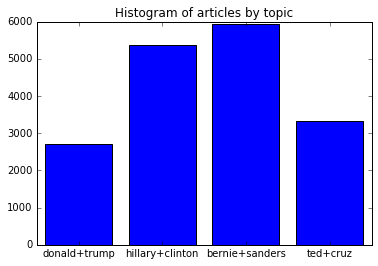

In [12]:
topics = ['donald+trump','hillary+clinton', 'bernie+sanders', 'ted+cruz']
plt.bar(list(set(target_)),counts, align='center')
plt.xticks(list(set(target_)),topics)
plt.title("Histogram of articles by topic")

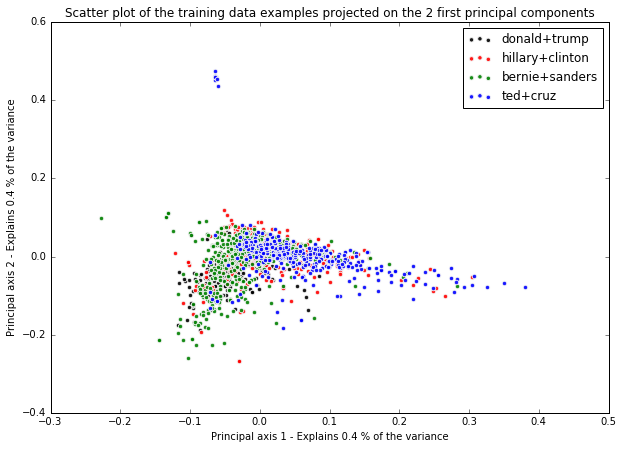

In [327]:
# plot first two principal components
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

data_ = normalize(data_)

pca = PCA(n_components=2).fit(data_)
data2D = pca.transform(data_)

# plt.scatter(data2D[:,0], data2D[:,1], c=target_)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = ['black','red','green','grey']
classes = list(set(target_))
for color, label, class_ix in zip(
        colors, topics, classes):
    ax.scatter(data2D[np.where(target_ == class_ix),0],
               data2D[np.where(target_ == class_ix),1],
               color=color, edgecolor='whitesmoke',
               linewidth='1', alpha=0.9, label=label)
    ax.legend(loc='best')
plt.title(
    "Scatter plot of the training data examples projected on the "
    "2 first principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(vectors, target, 
                                                    test_size=0.2, random_state=1729)
print(X_train.shape, X_test.shape)

(13861, 112061) (3466, 112061)


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

import pandas as pd

clf = MultinomialNB(alpha=1)
# clf = ExtraTreesClassifier(n_estimators = 25, criterion = "entropy", n_jobs=-1, 
#                            bootstrap=True, random_state=1729)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("F-score: ", metrics.f1_score(y_test, pred, average='weighted'))
print("Accuracy: ", metrics.precision_score(y_test, pred, average='weighted'))
print("Confusion matrix:\n", pd.crosstab(y_test, pred, rownames=['True'], 
                                         colnames=['Predicted']))

F-score:  0.676734513368
Accuracy:  0.781787904595
Confusion matrix:
 Predicted    0    1     2    3
True                          
0          103   81   358    6
1            0  927   173    8
2            0   75  1062    2
3            0  159   154  358


In [15]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, ",".join(np.unique(feature_names[top10])[0:20])))
        
# print ten most important words for each topic
show_top10(clf, vectorizer, le.classes_)

bernie+sanders: campaign,clinton,democratic,hillary,hillary clinton,mrs,mrs clinton,senator,senator vermont,vermont
donald+trump: cruz,mr,new,party,presidential,republican,republican presidential,said,ted,ted cruz
hillary+clinton: bernie,bernie sanders,campaign,democratic,mr,new,presidential,sanders,senator bernie,trump
ted+cruz: donald,donald trump,mr,mr trump,republican,rubio,senator,senator texas,texas,trump


In [16]:
# end timer
print(time.time()-start_time, 'seconds')

50.12165093421936 seconds


In [176]:
# test the model on articles written before 2013-December-13
test = get_data(TOPICS = ['donald+trump','hillary+clinton', 'bernie+sanders', 'ted+cruz'],
                ENDDATE = 20151213, NPAGES = [20,20,20,20])
test_data = [ x['snippet'] for x in test]
test_label = [ x['user_topic'] for x in test]

test_vectors = vectorizer.transform(test_data) 
test_target = le.transform(test_label)

print(test_vectors.shape, test_target.shape,'\n')
print("Number of unique words (features) across all docs: ", vectors.shape[1], '\n')
print("(docid, wordid) TFIDF", '\n')
print(vectors[0,])

Topics:  ['donald+trump', 'hillary+clinton', 'bernie+sanders', 'ted+cruz']
NPages:  [20, 20, 20, 20]
Date range:  20151212 -> 20130815 

Total documents:  80
Started download...
donald+trump is done | 20/80
hillary+clinton is done | 40/80
bernie+sanders is done | 60/80
ted+cruz is done | 80/80

Total documents returned:  80

Done in  4.933624029159546 seconds
(80, 200000) (80,) 

Number of unique words (features) across all docs:  200000 

(docid, wordid) TFIDF 

  (0, 111887)	0.160664254285
  (0, 187653)	0.160664254285
  (0, 194153)	0.1465742115
  (0, 195713)	0.16740688989
  (0, 183735)	0.16740688989
  (0, 183664)	0.16740688989
  (0, 102513)	0.16740688989
  (0, 114334)	0.160664254285
  (0, 49502)	0.160664254285
  (0, 194974)	0.144353666491
  (0, 189706)	0.160664254285
  (0, 130840)	0.160664254285
  (0, 129562)	0.160664254285
  (0, 187656)	0.160664254285
  (0, 194154)	0.160664254285
  (0, 108646)	0.13905797662
  (0, 111886)	0.160664254285
  (0, 187651)	0.1465742115
  (0, 195712)	0.1674

In [177]:
pred_test = clf.predict(test_vectors)
print("F-score: ", metrics.f1_score(test_target, pred_test, average='weighted'))
print("Accuracy: ", metrics.precision_score(test_target, pred_test, average='weighted'))
print("Confusion matrix:\n", pd.crosstab(test_target, pred_test, 
                                         rownames=['True'], colnames=['Predicted']))

F-score:  0.353362853363
Accuracy:  0.455366357069
Confusion matrix:
 Predicted  1   2  3
True               
0          0  20  0
1          8  12  0
2          0  20  0
3          9   5  6


//anaconda/envs/tpot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/tpot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, pred))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, pred))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, pred))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y_test, pred))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_test, pred, sample_size=1000))

Homogeneity: 0.358
Completeness: 0.453
V-measure: 0.400
Adjusted Rand-Index: 0.387
Silhouette Coefficient: 0.000


### Probabolistic Topic Modelling 
#### Latent Dirichlet Allocation

Example is [here](http://scikit-learn.org/dev/auto_examples/applications/topics_extraction_with_nmf_lda.html).

In [79]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 10

lda = LatentDirichletAllocation(n_topics=4, 
                                max_iter=5,
                                # doc_topic_prior = 0.1,
                                learning_method='online',
                                # learning_offset=50.,
                                random_state=1729)

lda.fit(vectors)

tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
president, washington, street, secretary, paul, obama, secretary state, ryan, department, private
Topic #1:
care, health, health care, town, muslims, town hall, hall, entering, refugees, united
Topic #2:
email sign, briefing email, evening latest, good evening, sign good, briefing, sign, wing, tax, san
Topic #3:
senator, trump, mr, clinton, republican, democratic, donald, presidential, donald trump, new



#### Non-negative Matrix Factorization

In [20]:
nmf = NMF(n_components=10, random_state=1,
          alpha=.01, l1_ratio=.5)

nmf.fit(vectors)
print_top_words(nmf, tf_feature_names, n_top_words)

Topic #0:
trump, mr, donald, donald trump, mr trump, senator texas, trump senator, said, texas, senator
Topic #1:
read latest, latest updates, updates, read, latest, updates mr, mr cruz, updates mrs, mrs clinton, mr
Topic #2:
new, york, new york, hampshire, new hampshire, primary, york times, times, tuesday, york primary
Topic #3:
presidential, republican, candidate, republican presidential, presidential candidate, democratic, democratic presidential, party, nomination, said
Topic #4:
clinton, hillary, hillary clinton, mrs, mrs clinton, senator, senator vermont, democratic, vermont, clinton senator
Topic #5:
cruz, ted, ted cruz, senator ted, cruz texas, senator, texas, mr cruz, republican, iowa
Topic #6:
iowa, bus tour, 28 town, day 28, town swing, faces culinary, selections, selections 2016, jan place, 2016 proper
Topic #7:
rubio, marco, marco rubio, senator, florida, senator marco, percent, rubio florida, texas, kasich
Topic #8:
sign good, good, sign, email sign, email, need know, mo

### LDAVis

In [76]:
import pyLDAvis

# K - Number of topics
# W - number of terms in vocabulary
# D - Number of documents

# Prepare data
phi = [x/sum(x) for x in lda.components_] # topic-term distributions, KxW matrix phi
theta = [x/sum(x) for x in lda.transform(vectors)] # document-topic distributions, DxK matrix theta
doc_lengths = [len(x) for x in vectorizer.inverse_transform(vectors)] # number of tokens per doc [312,
term_frequency = list(vectorizer.vocabulary_.values()) # freqs of terms in the corpus [8939, 5544

lda_data = {'topic_term_dists': phi, 
            'doc_topic_dists': theta,
            'doc_lengths': doc_lengths,
            'vocab': tf_feature_names,
            'term_frequency': term_frequency} 

In [77]:
lda_vis = pyLDAvis.prepare(**lda_data)

In [80]:
# Visualize data
pyLDAvis.display(lda_vis)

In [69]:
np.array(phi).shape

(4, 112061)

In [70]:
np.array(theta).shape

(17327, 4)

In [71]:
lda.components_.shape

(4, 112061)